# <a style="color:red"> 프로젝트: 뉴스 기사 요약해보기 </a>

### 평가 루브릭

(1) Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
-> 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


(2). 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
-> 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.


(3). Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  
-> 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

In [1]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.137.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.137.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [2]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Step 1. 데이터 수집하기

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
55713,New Zealand PM gets X-mas decor in nationwide ...,New Zealand's PM Jacinda Ardern has received a...
56646,"Don't trust Kuch Kuch Hota Hai, pyaar dosti na...","Filmmaker Karan Johar, while talking about rel..."
70153,E-vehicle charging pods to be compulsory in K'...,The Karnataka government will reportedly make ...
47711,Farah turned down chance to choreograph DDLJ s...,Filmmaker Karan Johar has revealed Farah Khan ...
67044,FIFA launches Hindi Twitter account ahead of U...,World football body FIFA has launched a Twitte...
73163,I have no regrets: Hrithik on his Bollywood ca...,"Actor Hrithik Roshan, while talking about his ..."
70868,"I'm a public figure, not public property: Ilea...","Actress Ileana D'Cruz, while speaking about an..."
83511,"After Jaipur, Pakistan Police trolls Bumrah fo...","After Jaipur Traffic Police, Indian bowler Jas..."
6891,It was a massive shock: Gambhir on Dhoni's 201...,Recalling the then India captain MS Dhoni's se...
57583,Kumbh Mela in UNESCO's Intangible Cultural Her...,The Kumbh Mela has been included in the UNESCO...


In [6]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


데이터는 제목(headlines)과 내용(text)로 구성되었다.  
여기서 내용(text)을 훈련을 위한 X 데이터로 하고, 제목(headlines)을 타겟 데이터인 y로 하여 학습한다.

# Step 2. 데이터 전처리하기(추상적 요약)

중복 샘플 유무 확인

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


다른 text에도 같은 headline이 있다는 결과  
text 자체도 중복되는 것이 40여개 있다 -> 본문이 같다는 말이므로 제거해줘야 함

중복 샘플 제거

In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


Null값이 있는지 확인

In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 값은 없으므로 따로 처리하지 않음

텍스트 정규화 준비(it'll = it will 과 같은 사례를 동일시 하기 위해)

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 알아보기(NLTK에서 미리 정의하여 제공하는 불용어) 

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수 정의  
(길이가 짧은 summary에서는 불용어를 없애지 않는 것이 자연스러울 것이라고 판단하여 불용어 제거하지 않음)

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary) -> 길이가 짧으므로 불용어를 제거하면 자연스럽지 않을 것이라 예상
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 함수의 성능을 확인하기

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


Text 전처리!

In [14]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

summary 전처리!

In [15]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


다시 한번 빈(empty) 샘플이 생겼는지 확인  
보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장
빈(empty) 샘플은 Null로 대체

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

Null 값 없으므로 건너뛰기

#### 샘플의 최대 길이 정하기

길이 분포 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트 길이의 표준편차 : 3.7993861876499637
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534
헤드라인 길이의 표준편차 : 1.3900944321771693


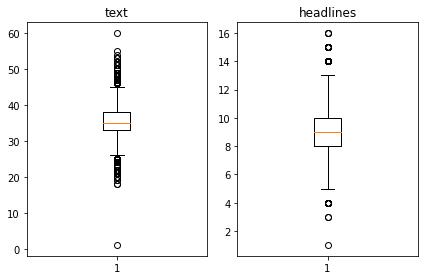

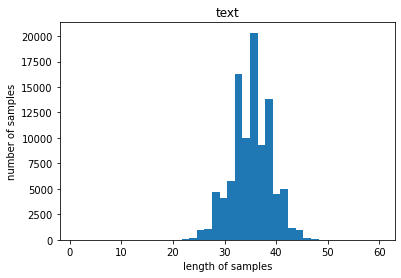

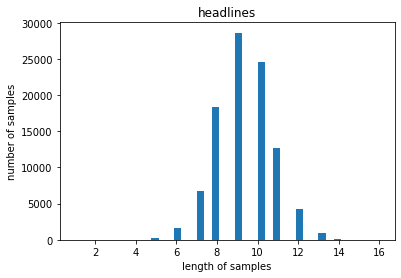

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트 길이의 표준편차 : {}'.format(np.std(text_len)))

print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))
print('헤드라인 길이의 표준편차 : {}'.format(np.std(summary_len)))


plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

분포를 확인하고 최대 길이를 설정  
평균+(표준편차\*1.5)값으로 설정한다!

In [19]:
text_max_len = int(np.mean(text_len) + (np.std(text_len)*1.5))
print('text의 최대 길이: {}'.format(text_max_len))
summary_max_len = int(np.mean(summary_len) + (np.std(summary_len)*1.5))
print('headlines의 최대 길이: {}'.format(summary_max_len))

text의 최대 길이: 40
headlines의 최대 길이: 11


최대 길이가 어느정도 데이터를 포함하는지 확인하는 함수 정의

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


길이를 제한하면 일부 데이터들은 망가지게 되는데,  
이를 방지하기 위해 길이가 긴 데이터를 자르지 않고 제외시킴

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


#### 시작 토큰과 종료 토큰 추가하기

시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가  
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,  
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 명명

In [23]:
# summary 열에서 수행
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


인코더 입력과 디코더 입력, 디코더 레이블을 numpy 형식으로 저장

In [24]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

훈련 데이터와 테스트 데이터를 직접 분리  
encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices) # 순서를 랜덤하게 섞어준다
print(indices)

[33534 52518 63962 ... 44073 11872 42026]


데이터의 순서 섞어주기

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

훈련과 테스트를 8:2로 나누기 위해 테스트 데이터의 크기를 정해줌

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


데이터 분리하기

In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


디코더의input과 target 데이터의 수는 같다

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [29]:
# keras의 토크나이저를 활용
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

빈도수가 낮은 단어를 제외하기 위해 빈도수가 8번 미만인 단어를 확인

In [30]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64594
등장 빈도가 7번 이하인 희귀 단어의 수: 45443
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19151
단어 집합에서 희귀 단어의 비율: 70.35173545530544
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.185828475167603


빈도수가 7번 이하인 단어의 비율이 약 70% 정도로 높지만, 전체 빈도수 중에는 약 3.9% 밖에 되지 않는다.  
그러므로 이 단어들을 제외!

노드상에는 8000여개라고 했지만 프로젝트에서는 20629개 였기에 단어 크기를 20500개로 제한

In [31]:
src_vocab = 20500
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,500으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

텍스트 시퀀스를 정수 시퀀스로 변환

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1094, 671, 74, 149, 108, 363, 155, 1116, 139, 1280, 1290, 199, 10053, 5012, 2701, 2438, 1116, 810, 52, 1425, 19152, 9391, 9823, 810, 1280, 10053, 1173, 4093, 19152, 16979, 7194, 96, 1948, 162, 155, 671, 1443, 12682, 1116, 810], [40, 99, 1196, 1880, 942, 1117, 7, 65, 715, 15384, 11, 1973, 197, 293, 860, 149, 108, 65, 1880, 158, 2236, 11, 197, 14740, 3617, 8500, 16980, 8334, 1271, 704, 7, 4025, 3124, 99], [1207, 1646, 7653, 1434, 974, 208, 1759, 72, 355, 1669, 261, 1109, 1396, 73, 131, 880, 11538, 2701, 70, 7653, 1202, 16981, 681, 1207, 1646, 248, 2981, 1835, 5582, 2352, 314, 1214, 9392, 3589]]


headlines 데이터에 대해서도 동일한 작업 수행

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
# tar_tokenizer.word_index에 단어데 대해 생성된 고유 정수 저장되어 있음

빈도수가 8 미만인 데이터 확인

In [34]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28397
등장 빈도가 7번 이하인 희귀 단어의 수: 20226
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8171
단어 집합에서 희귀 단어의 비율: 71.22583371482904
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.603263371076131


빈도수가 7번 이하인 비율이 약 70% 이지만 정체 빈도에 대한 비율을 약 6%가 채 되지 않는다.  
그러므로 어림잡아 8700개로 단어를 제한!

In [35]:
tar_vocab = 8700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 285, 106, 164, 8, 481, 5666, 3, 141, 17, 334], [1, 35, 116, 443, 5, 3427, 4, 814], [1, 525, 849, 5984, 1061, 405, 1774, 254, 1276, 104, 4, 1216], [1, 329, 832, 6661, 3, 176, 804, 832], [1, 1553, 19, 6, 359, 739, 883, 3428]]
target
decoder  [[285, 106, 164, 8, 481, 5666, 3, 141, 17, 334, 2], [35, 116, 443, 5, 3427, 4, 814, 2], [525, 849, 5984, 1061, 405, 1774, 254, 1276, 104, 4, 1216, 2], [329, 832, 6661, 3, 176, 804, 832, 2], [1553, 19, 6, 359, 739, 883, 3428, 2]]


평균 길이가 약 9 정도이기에 headlines는 단어수를 제한해도 빈 샘플이 발생했을 가능성이 높지는 않다.  
그래도 시작 토큰이나 종료 토큰만 남은 길이가 1인 샘플들을 제거해야 하므로 확인해보자!

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17167
테스트 레이블의 개수 : 17167


정제된 데이터를 최대 길이로 패딩하자!

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

함수형 API를 활용한 인코더 모델 설계

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더 설계  
time step마다 dropout을 해주는 recurrent dropout을 적용

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더 출력층 설계!

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2624000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

어텐션 메커니즘
- 디코더의 출력층을 조금 바꿔서 성능을 높일 수 있는 방법
- Tensorflow에 이미 정의된  Bahdanau 스타일의 어텐션을 불러와서 적용

어텐션 층을 만들고 디코더 출력층을 수정

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2624000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,  
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동  
빠른 속도를 위해 colab의 TPU를 활용!

In [42]:
with strategy.scope():
  # 인코더
  encoder_inputs = Input(shape=(text_max_len,))

  # 인코더의 임베딩 층
  enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

  # 인코더의 LSTM 1
  encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  # 인코더의 LSTM 2
  encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  # 인코더의 LSTM 3
  encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # 디코더 설계
  decoder_inputs = Input(shape=(None,))

  # 디코더의 임베딩 층
  dec_emb_layer = Embedding(tar_vocab, embedding_dim)
  dec_emb = dec_emb_layer(decoder_inputs)

  # 디코더의 LSTM
  decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
  decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

  # 어텐션 층(어텐션 함수)
  attn_layer = AdditiveAttention(name='attention_layer')

  # 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
  attn_out = attn_layer([decoder_outputs, encoder_outputs])


  # 어텐션의 결과와 디코더의 hidden state들을 연결
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  # 디코더의 출력층
  decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
  decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

  model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


269/269 [==============================] - 57s 119ms/step - loss: 5.9276 - val_loss: 5.5256
Epoch 2/50
269/269 [==============================] - 14s 54ms/step - loss: 5.3905 - val_loss: 5.1839
Epoch 3/50
269/269 [==============================] - 14s 54ms/step - loss: 5.0617 - val_loss: 4.9128
Epoch 4/50
269/269 [==============================] - 15s 54ms/step - loss: 4.7866 - val_loss: 4.6996
Epoch 5/50
269/269 [==============================] - 15s 55ms/step - loss: 4.5551 - val_loss: 4.5587
Epoch 6/50
269/269 [==============================] - 14s 54ms/step - loss: 4.3687 - val_loss: 4.4222
Epoch 7/50
269/269 [==============================] - 15s 54ms/step - loss: 4.2072 - val_loss: 4.3154
Epoch 8/50
269/269 [==============================] - 15s 54ms/step - loss: 4.0653 - val_loss: 4.2495
Epoch 9/50
269/269 [==============================] - 15s 54ms/step - loss: 3.9410 - val_loss: 4.1713
Epoch 10/50
269/269 [==============================] - 14s 54ms/step - loss: 3.8304 - val_lo

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

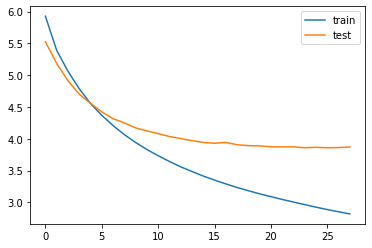

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

정수로 존재하는 텍스트 데이터를 실제 데이터로 복원하기 위한 사전 준비

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련 단계와 다르게 인퍼런스 단계에서는 만들어줘야하는 문장의 길이만큼 디코더가 반복 구조로 동작해야함  
그러므로 인퍼런스를 위한 모델 설계를 별도로 해주어야 함  
이 때, 인코더와 디코더 모델을 분리해서 설계!

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층 설계

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 시퀀스를 완성하는 함수 정의

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

모델 테스트하기

정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 정의  
출력할 때 패딩 0과 시작 토큰, 출력 토큰은 제외되도록!!

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개에 대해 결과 확인!

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actor salman khan among targets lawrence bishnoi gang gangster nehra assigned kill per haryana police went mumbai two days clicked photographs took note actor movement around balcony house galaxy apartment possibly assess distance weapon required added police 
실제 요약 : gangster to kill salman him for days police 
예측 요약 :  salman khan brother found in salman khan house


원문 : german police tuesday said arrested year old man connection security breach affected estimated people including hundreds country politicians police searched suspect apartment arrested sunday personal data documents politicians including chancellor angela merkel published online part breach 
실제 요약 : year old arrested over data breach of german politicians 
예측 요약 :  arrested for duping people in sudan


원문 : england limited overs captain eoin morgan tweeted support victims floods kerala morgan tweeted thoughts prayers everyone kerala horrific floods earlier indian cricketer sanju samson hails state donated lakh h

# Step 5. Summa을 이용해서 추출적 요약해보기

#### 데이터 다운로드하기

In [56]:
pip install summa

     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=b5de51fb23e0180a807739f7f6cf59c45e59d0a3ee3c981366e143557eb8975a
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [57]:
import requests
from summa.summarizer import summarize

매트릭스 시놉시스 다운

In [58]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [59]:
text = data["text"]

데이터 출력해보기(하나만)

In [60]:
print(text[200])

Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year. Harmanpreet, who was named in the ICC Team of the Year 2018, helped India reach the semi-finals of the ICC Women's World T20 2018 last November.


#### Summarize 사용하기

원문의 50%까지만 출력하도록 설정하여 요약 결과 출력해보기

In [61]:
nums=94

print('headlines:')
print(summarize(text[nums], ratio=0.5))

headlines:
While speaking about winning awards for his films, Shah Rukh Khan said, "If I don't get an award, that award is at a loss." "Sometimes, the prestige of an award increases when I receive it," the actor jokingly added.


출력 결과를 리스트로 받기

In [62]:
print('headlines:')
print(summarize(text[nums], ratio=0.5, split=True))

headlines:
['While speaking about winning awards for his films, Shah Rukh Khan said, "If I don\'t get an award, that award is at a loss." "Sometimes, the prestige of an award increases when I receive it," the actor jokingly added.']


단어수로 요약 결과의 크기를 조절할 수 있음  
(30개로 설정)

In [63]:
print('haedlines:')
print(summarize(text[nums], words=30))

haedlines:
While speaking about winning awards for his films, Shah Rukh Khan said, "If I don't get an award, that award is at a loss." "Sometimes, the prestige of an award increases when I receive it," the actor jokingly added.


text 리스트의 텍스트들을 전부 요약하기

In [64]:
summaries = []
for t in text:
    summary = summarize(t, words=int(len(t.split(' '))*0.3))
    summaries.append(summary)

In [65]:
summaries[:5]

["upGrad's Online Power Learning has powered 3 lakh+ careers.",
 'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.',
 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.',
 'Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.',
 '']

In [66]:
for i in range(50, 100):
    print("원문 :", data["text"][i])
    print("실제 요약 :", data["headlines"][i])
    print("예측 요약 :", summaries[i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

---
---

# 회고

(1) 기본적으로 노드에서 제시한 단게를 모두 알맞게 수행했다.  
미리 정의된 정규화 사전을 활용했고, 불용어 제거도 NLTK에 정의된 불용어를 활용하여 전처리 과정을 수행했다.  
이렇게 미리 정의된 것들이 있어 활용하는 것이 굉장히 수월했다.  
인코더와 디코더, 어텐션 메커니즘까지 활용하여 모델을 학습했다.

(2) loss 변화를 그래프로 확인해보았을 때, train loss는 계속해서 줄어드는 모습을 보였지만,  
test loss는 약 20번의 epoch 후 부터는 거의 수렴하는 모습을 볼 수 있다.  
학습한 모델을 이용하여 헤드라인을 예측해보았을 때, 어느정도 의미있는 문장을 보여주는 것을 확인할 수 있다.  

(3) 추상적 요약방법의 결과는 실제 헤드라인과 차이가 꽤 있었고, 같은 단어가 반복되는 문제가 발생하기도 했다.  
또한, 문법적으로도 어색한 부분이 있었다.  
LSTM 층을 더 쌓거나, 양방향 RNN을 활용하면 성능이 개선될 것이라고 생각한다. 
추가적으로 테스트 데이터에도 불용어를 제거하면 좀 더 자연스러운 결과가 나오지 않을까 한다.


추출적 요약방법은 말 그대로 텍스트 전문에서 일부분을 추출하는 것이므로, 문법적으로는 어색하지 않다.  
아무래도 추상적 요약에 비해 좀 더 의미있는 문장이 나온 것들도 많으나 그렇지 않은 것도 많다.  
또한, 출력 문장의 길이를 제한하다보니 아예 출력을 못하는 경우도 적지 않게 발생한다.


그러므로 조금의 어색함은 있어도 추상적 요약방법의 성능을 개선하여 활용하는 편이 더 좋은 결과를 볼 것이라고 생각한다